# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set random seed for results reproducibility
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset tickers and pull returns data:
# Set ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()
df.tail()

,AGG,SPY
,close,close
time,,
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86
2019-12-30 00:00:00-05:00,112.630,321.10
2019-12-31 00:00:00-05:00,112.370,321.92


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
avg_return=pd.DataFrame(df.pct_change().mean())
avg_return.index=['AGG', 'SPY']
avg_return.columns=['1Yr Mean']
avg_return.head()
# Display sample data
avg_return.loc["AGG","1Yr Mean"]
avg_return.loc["SPY","1Yr Mean"]
print(avg_return.head())

     1Yr Mean
AGG  0.000213
SPY  0.001040


In [7]:
# Compute daily volatility over a one year horizon
OneYr_Vol=pd.DataFrame(df.pct_change().std())
OneYr_Vol.index=['AGG', 'SPY']
OneYr_Vol.columns=['1Yr Vol']
OneYr_Vol.head()

,1Yr Vol
AGG,0.00209
SPY,0.00782


In [8]:
# Save the last day's closing price
agg_last_closing=df["AGG"]["close"][-1]
spy_last_closing=df["SPY"]["close"][-1]

In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
number_years = 30  #added parameter for number of years
monte_carlo = pd.DataFrame()

In [10]:
# Run the Monte Carlo Simulation


# Initialized empty DataFrame to hold simulated prices for each simulation
WRate=0.04
portfolio_cumulative_returns = pd.DataFrame()
portfolio_cumulative_returns_with_withdrawal=pd.DataFrame()
portfolio_daily_returns_withdrawal=pd.DataFrame()

# Ran simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_agg_prices = [agg_last_closing]
    simulated_spy_prices = [spy_last_closing]
    
    # Simulate returns for 252 * 30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_return.loc["AGG","1Yr Mean"], OneYr_Vol.loc["AGG","1Yr Vol"]))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_return.loc["SPY","1Yr Mean"], OneYr_Vol.loc["SPY","1Yr Vol"]))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60/40 portfolio SPY and AGG)
    weights = [0.4, 0.6]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns. Some extra code on withdrawal is included which speaks to previous question
  
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_daily_returns_withdrawal=simulated_daily_returns.dot(weights)
    for withdrawal in range(number_years):
        portfolio_daily_returns_withdrawal.iloc[(withdrawal+1)*252] = portfolio_daily_returns_withdrawal.iloc[(withdrawal+1)*252]-WRate
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    portfolio_cumulative_returns_with_withdrawal[n] = (1 + portfolio_daily_returns_withdrawal.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()
#portfolio_cumulative_returns_with_withdrawal.head()
#portfolio_daily_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000476,1.000536,0.998808,1.005394,1.011797,0.994452,0.997251,1.013277,1.000869,0.995376,...,1.002066,0.992709,1.001801,1.002671,0.996472,1.003160,1.001638,1.006800,0.998173,0.994765
2,1.008876,1.004699,1.003590,0.996711,1.009571,0.994247,0.994214,1.007199,1.000225,0.993036,...,1.005759,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005408,0.996137,0.998871
3,1.008286,1.004228,1.003770,0.998232,1.007751,0.987669,0.998229,1.001361,1.000230,1.001279,...,1.006771,0.988444,1.004118,1.010565,0.993293,0.994454,1.008272,0.999144,0.998656,1.003328
4,1.013963,1.006575,1.008493,1.002636,1.013664,0.990972,1.003241,0.995491,1.002048,1.006036,...,1.004196,0.992123,1.004724,1.004423,0.994844,0.993782,1.005722,1.002248,0.996964,1.004095


In [11]:
monte_carlo.tail()
portfolio_cumulative_returns.iloc[-1,:].mean()
portfolio_cumulative_returns.iloc[-1,:].median()

199.08385717168744

In [12]:
# Check that the simulation ran successfully
print(f"Monte Carlo Estimates Mean and Median: {round(portfolio_cumulative_returns.iloc[-1,:].median(),2)}, {round(portfolio_cumulative_returns.iloc[-1,:].mean(),2)}")
print(f"Base Estimates {(1+avg_return.T.dot(weights))**number_records-1}")
# The code above compares the mean and median of the Cumulative Returns Monte Carlo distribution with a base case i.e. 1 day mean AGG and SPY return compounded over 252*30 trading days


Monte Carlo Estimates Mean and Median: 199.08, 213.93
Base Estimates 1Yr Mean    211.62511
dtype: float64


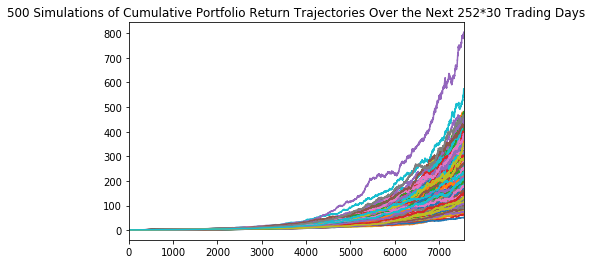

In [13]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252*30 Trading Days"
portfolio_cumulative_returns.plot(legend=None,title=plot_title)
#plt.legend()

count    500.000000
mean     213.934520
std       87.478242
min       51.574092
25%      152.963137
50%      199.083857
75%      261.353269
max      804.011725
Name: 7560, dtype: float64


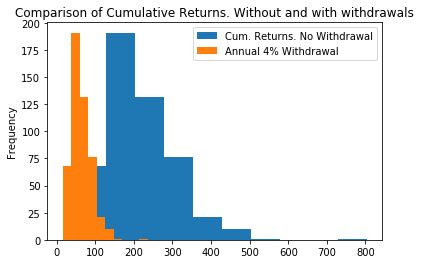

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
print(portfolio_cumulative_returns.iloc[-1,:].describe())
portfolio_cumulative_returns.iloc[-1,:].plot(kind="hist",label='Cum. Returns. No Withdrawal',bins=10)
portfolio_cumulative_returns_with_withdrawal.iloc[-1,:].plot(kind="hist",label='Annual 4% Withdrawal',bins=10)
plt.title("Comparison of Cumulative Returns. Without and with withdrawals", fontdict=None, loc='center', pad=None)
plt.legend()

In [15]:
portfolio_cumulative_returns.iloc[-1,:].value_counts(bins=10) / len(portfolio_cumulative_returns.iloc[-1,:])
#portfolio_cumulative_returns_with_withdrawal.iloc[-1,:].value_counts(bins=10) / len(portfolio_cumulative_returns.iloc[-1,:])

(126.818, 202.062]               0.382
(202.062, 277.305]               0.264
(277.305, 352.549]               0.152
(50.821000000000005, 126.818]    0.136
(352.549, 427.793]               0.042
(427.793, 503.037]               0.020
(728.768, 804.012]               0.002
(503.037, 578.28]                0.002
(653.524, 728.768]               0.000
(578.28, 653.524]                0.000
Name: 7560, dtype: float64

In [16]:
#Frequency distribution of portflio cumulative returns
portfolio_cumulative_returns.iloc[-1,:].value_counts(bins=15) 

(151.899, 202.062]               135
(101.737, 151.899]               101
(202.062, 252.224]                99
(252.224, 302.387]                79
(302.387, 352.549]                30
(50.821000000000005, 101.737]     23
(402.712, 452.874]                13
(352.549, 402.712]                13
(452.874, 503.037]                 5
(753.849, 804.012]                 1
(553.199, 603.362]                 1
(703.687, 753.849]                 0
(653.524, 703.687]                 0
(603.362, 653.524]                 0
(503.037, 553.199]                 0
Name: 7560, dtype: int64

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
portfolio_cumulative_returns.iloc[-1,:] # return at 30 years
print(f"90th %ile is {portfolio_cumulative_returns.iloc[-1,:].quantile(q=0.9):,.2f}")

90th %ile is 320.56


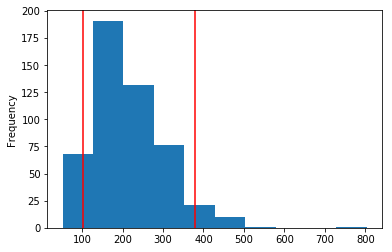

In [18]:
# Display the 90% confidence interval for the ending returns (red line)
ending_cumulative_returns=portfolio_cumulative_returns.iloc[-1,:]
confidence_interval_30 = ending_cumulative_returns.quantile(q=[0.05, 0.95])
ending_cumulative_returns.plot(kind='hist', bins=10)
plt.axvline(confidence_interval_30.iloc[0], color='r')
plt.axvline(confidence_interval_30.iloc[1], color='r')

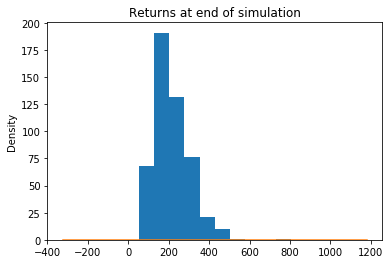

In [19]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind="hist",legend=None, title="Returns at end of simulation")
ending_cumulative_returns.plot(kind="kde",legend=None, title="Returns at end of simulation")

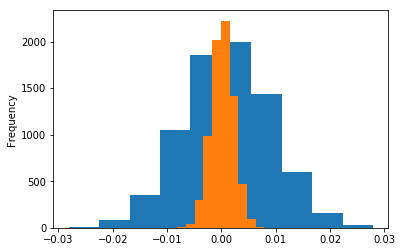

In [20]:
#Helps visualize relative distributions of AGG and SPY to confirm MC estimates
monte_carlo["SPY prices"].pct_change().plot(kind="hist") #confirms daily distribution of prices for a single sample
monte_carlo["AGG prices"].pct_change().plot(kind="hist") #confirms daily distribution of prices for a single sample

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

[Text(0, 0, '10th'), Text(0, 0, '50th'), Text(0, 0, '95th')]

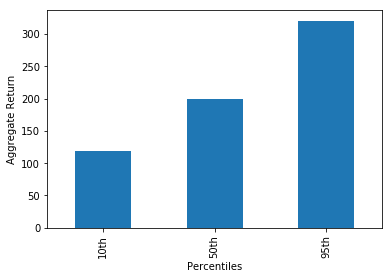

In [21]:
# Compute cumulative returns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
ax=ending_cumulative_returns.quantile(q=[.1,.5,.9]).plot(kind="bar")
#ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set(xlabel="Percentiles", ylabel="Aggregate Return")
ax.set_xticklabels(['10th','50th','95th'])

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [22]:
# Set initial investment
initial_investment=20000
# Compute expected portfolio return
portfolio_return_dollars=ending_cumulative_returns.quantile(q=[.1,.5,.9])*initial_investment
output=zip(['10th %ile','50th %ile','95th %ile'],round(portfolio_return_dollars,0))
list(output)


[('10th %ile', 2380550.0), ('50th %ile', 3981677.0), ('95th %ile', 6411231.0)]

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

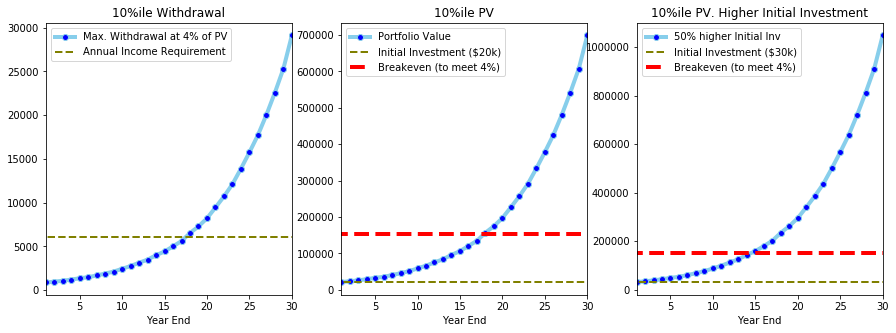

In [23]:
# Set Plaid's projected income
## Module to calculate retirement income assuming a 4% withdrawal is made at the last trading day of each year starting Yr 1
## Permits visualization of a breakeven rate when the portfolio comes close to meeting Yield Requirements shown in graphs below
import matplotlib.pyplot as plt
projected_yearly_income=6085
YearlyIncome=[projected_yearly_income]*31
projected_yearly_income_before_tax=7389
WithdrawalRate=0.04
PortValue=[]
MarketValue=[]
# Calculate the 4% withdrawal for the ending return as retirement income
for years in range(number_years):
    testlist=portfolio_cumulative_returns_with_withdrawal.iloc[(years+1)*252,:].quantile(q=[.1])*initial_investment*WRate/(1-WRate)
    testlist1=portfolio_cumulative_returns_with_withdrawal.iloc[(years+1)*252,:].quantile(q=[.1])*initial_investment
    PortValue.append(testlist.values)
    MarketValue.append(testlist1.values)
    #WithdrawalDollars[years+1][0]=testlist.values
#print(WithdrawalDollars)

DFIndex=list(range(1,number_years+1))

WithdrawalDollars=pd.DataFrame(data=PortValue,index=DFIndex,columns=['Max. Withdrawal at 4% of PV'])
WithdrawalDollars.index.name="Year End"
WithdrawalDollars['Portfolio Value']=MarketValue
WithdrawalDollars['Portfolio Value']=WithdrawalDollars['Portfolio Value'].astype(float)
WithdrawalDollars['50% higher Initial Inv']=WithdrawalDollars['Portfolio Value']*1.5

fig = plt.figure(figsize=(15,5))
fig.tight_layout(pad=6.0)
plt.subplot(1, 3, 1)
ax1=WithdrawalDollars['Max. Withdrawal at 4% of PV'].plot(kind="line",title="10%ile Withdrawal",marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)
ax1.plot(YearlyIncome,marker='', color='olive', linewidth=2, linestyle='dashed', label="Annual Income Requirement")
plt.legend()
plt.subplot(1, 3, 2)
ax2=WithdrawalDollars['Portfolio Value'].plot(kind="line",title="10%ile PV",marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)
ax2.plot([initial_investment]*31,marker='', color='olive', linewidth=2, linestyle='dashed', label="Initial Investment ($20k)")
ax2.plot([projected_yearly_income/WithdrawalRate]*31,marker='', color='red', linewidth=4, linestyle='dashed', label="Breakeven (to meet 4%)")
plt.legend()
plt.subplot(1, 3, 3)
ax2=WithdrawalDollars['50% higher Initial Inv'].plot(kind="line",title="10%ile PV. Higher Initial Investment",marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)
ax2.plot([initial_investment*1.5]*31,marker='', color='olive', linewidth=2, linestyle='dashed', label="Initial Investment ($30k)")
ax2.plot([projected_yearly_income/WithdrawalRate]*31,marker='', color='red', linewidth=4, linestyle='dashed', label="Breakeven (to meet 4%)")
plt.legend()
plt.savefig("Withdrawal Options.png")

## Explanation of solution
Logic:
A withdrawal of 4% is made on the last trading day of the first year onwards (as interpreted from the original problem) i.e.Day 252, Day 504 upto Day 7560 i.e. 30 Yrs.
The graph on left compares 4% withdrawal to the income requirement from Plaid
As can be seen only between Yr 15 and 20 does 4% of portfolio value (@10%ile) equal income requirement; stated differently prior to this a 4% annual withdrawal will not meet retirement needs based on initial investment of $20k and asset mix.
The graph in the middle presents the raw portfolio value. To sustain 4% withdrawal of $6k, the portflio size should atleast be ~ $150k atleast. This cutoff is also shown in middle graph.
The graph on right uses an intial investment of $Thirty Thousand. This moves intersection to left(blue and dashed red lines), portfolio still needs ~15 years to sustain the ~$6000 withdrawal.

In [24]:
# Solution per revised problem posted on README
OneYearPortfolioValue=portfolio_cumulative_returns.iloc[252,:].quantile(q=[.1])*initial_investment
WithDollar_20k=float(OneYearPortfolioValue.values*WRate)
print(f"MC at 10%ile is $ {WithDollar_20k:,.2f}")
print(f"Your withdrawal Requirement is ${projected_yearly_income:,.2f}")
if WithDollar_20k>projected_yearly_income:
      print("Success: Asset Mix and Investent Sufficient")
else:
      print("Increase initial investment or change asset mix")


MC at 10%ile is $ 877.58
Your withdrawal Requirement is $6,085.00
Increase initial investment or change asset mix


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [25]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
# Solution per revised problem posted on README
OneYearPortfolioValue=portfolio_cumulative_returns.iloc[252,:].quantile(q=[.1])*initial_investment
WithDollar_30k=float(OneYearPortfolioValue.values*WRate*1.5)
print(f"MC at 10%ile is $ {WithDollar_30k:,.2f}")
print(f"Your withdrawal Requirement is ${projected_yearly_income:,.2f}")
if WithDollar_30k>projected_yearly_income:
      print("Success: Asset Mix and Investent Sufficient")
else:
      print("Increase initial investment or change asset mix")
      print("Does not meet your retirement needs")

MC at 10%ile is $ 1,316.36
Your withdrawal Requirement is $6,085.00
Increase initial investment or change asset mix
Does not meet your retirement needs


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [26]:
# Compute projected returns and sample data
NewReturns=portfolio_cumulative_returns.T.quantile([.05, .5, 0.95])*initial_investment

NewReturns.head()



,0,1,2,3,4,5,6,7,8,9,...,7551,7552,7553,7554,7555,7556,7557,7558,7559,7560
0.05,20000.0,19853.811113,19808.750045,19787.659380,19764.821308,19710.150941,19701.436270,19691.415602,19683.957376,19632.512001,...,2.065004e+06,2.056413e+06,2.059181e+06,2.061957e+06,2.068354e+06,2.072924e+06,2.060979e+06,2.062480e+06,2.057766e+06,2.056512e+06
0.50,20000.0,20015.691198,20025.743648,20046.561490,20059.444964,20075.595936,20094.545143,20108.482143,20111.820648,20142.990577,...,3.921931e+06,3.930553e+06,3.938887e+06,3.935087e+06,3.950591e+06,3.960921e+06,3.971434e+06,3.971648e+06,3.988083e+06,3.981677e+06
0.95,20000.0,20171.457229,20265.768514,20314.543378,20366.172768,20434.511818,20466.494457,20508.738736,20543.910724,20590.030705,...,7.556621e+06,7.613399e+06,7.643444e+06,7.641493e+06,7.632592e+06,7.642515e+06,7.624367e+06,7.604815e+06,7.598804e+06,7.586836e+06


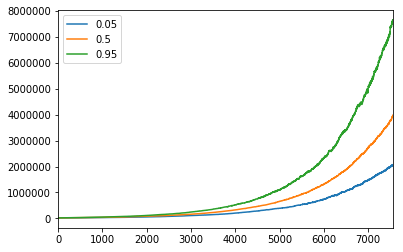

In [27]:
# Cumulative returns over time
NewReturns.T.plot()

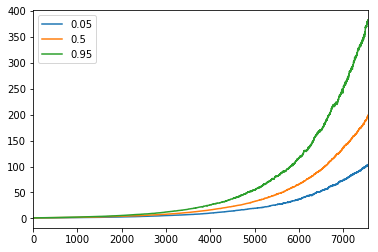

In [28]:
# Compute portfolio performance over time
portfolio_perfomance_time=portfolio_cumulative_returns.T.quantile([.05, .5, 0.95])
portfolio_perfomance_time.head()
# Plot projected performance over time
portfolio_perfomance_time.T.plot()

In [29]:
# Bonus Problem. Set up widgets to accept Asset Mix (% in Stocks) and Initial Investment ($)
import ipywidgets as widgets
from matplotlib.widgets import Slider, Button, RadioButtons
AssetMix=widgets.IntSlider(
    min=50,
    max=90,
    step=5,
    description='Asset Mix in SPY:',
    value=3
)
InitialInv=widgets.IntSlider(
    min=20000,
    max=200000,
    step=5000,
    description='Initial Investment:',
    value=5
)


In [30]:
# Function which accepts asset mix and initial investment as input and returns the withdrwal dollars which is Portfolio Value* Withdrawal Rate 4%. This is compared with Plaid output)
def WidgetMonteCarlo(mix,investment):
    portfolio_cumulative_returns_new = pd.DataFrame()
    number_years_new=5
    number_simulations=500
    number_records_new=number_years_new*252
    
    for n in range(number_simulations):
        simulated_agg_prices = [agg_last_closing]
        simulated_spy_prices = [spy_last_closing]
        
        for i in range(number_records_new):
            simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_return.loc["AGG","1Yr Mean"], OneYr_Vol.loc["AGG","1Yr Vol"]))
            simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_return.loc["SPY","1Yr Mean"], OneYr_Vol.loc["SPY","1Yr Vol"]))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
        monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
        monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
        
        # Calculate the daily returns of simulated prices
        simulated_daily_returns = monte_carlo.pct_change()
        
        # Set the portfolio weights (Passed as arguments; with function input being mix in stocks)
        weights = [(100-mix)/100, mix/100]
        portfolio_daily_returns = simulated_daily_returns.dot(weights)
        portfolio_cumulative_returns_new[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    TenPercentile=portfolio_cumulative_returns_new.iloc[-1,:].quantile(q=[.1])
    TenPercentileDollars=float(TenPercentile.values*investment*WRate)
    return(TenPercentileDollars)
 

All Calculations Expressed in the 10%ile to imply 90% success of meeting your goals
Success: Asset Mix and Investent Sufficient
With 60.00% in stocks and $ 175000.00 initial investment you meet target withdrawal rates
You needed $6,085.00 but portfolio yielded $6,964.35


<Figure size 432x288 with 0 Axes>

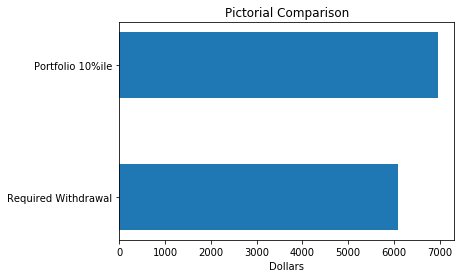

<Figure size 432x288 with 0 Axes>

In [34]:
# Module to define widgets and accept Asset Mix and Initial Investment as inputs
from IPython.display import display, Markdown, clear_output
display(InitialInv)
display(AssetMix)
print("Set Initial Investment and Asset Mix in Stocks")
def CallWidgetMonteCarlo(change):
    clear_output()
    print("All Calculations Expressed in the 10%ile to imply 90% success of meeting your goals")
    EstimatedWithDollars=WidgetMonteCarlo(change['new'],InitialInv.value)
    if EstimatedWithDollars>=projected_yearly_income:
        print("Success: Asset Mix and Investent Sufficient")
        print(f"With {change['new']:,.2f}% in stocks and $ {InitialInv.value:.2f} initial investment you meet target withdrawal rates")
        print(f"You needed ${projected_yearly_income:,.2f} but portfolio yielded ${EstimatedWithDollars:,.2f}")
    else:
        print(f"With {change['new']:,.2f}% in stocks and $ {InitialInv.value:.2f} initial investment you do not meet target withdrawal rates")
        print(f"Your target withdrawal is ${projected_yearly_income:,.2f} but portfolio only yields ${EstimatedWithDollars:,.2f}")
        print("Increase initial investment or change asset mix")
              
    fig, ax = plt.subplots()
    Options = ('Portfolio 10%ile', 'Required Withdrawal')
    y_pos = np.arange(len(Options))
    performance = [EstimatedWithDollars,projected_yearly_income]
    ax.barh(y_pos,performance,height=0.5,align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(Options)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Dollars')
    ax.set_title('Pictorial Comparison')
    plt.show()
    plt.savefig("Withdrawal_Output.png")         
AssetMix.observe(CallWidgetMonteCarlo,names='value')